In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 500

### Загрузим датасет с машинами. Цель - верно восстанавливать для каждой из них цену продажи!

In [14]:
data = pd.read_csv('autos.csv')

data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [15]:
### Колонка с тергетом - "selling price"

X = data.drop("selling_price", axis=1)
y = data["selling_price"]

### Будем замерять MSLE!
### Поэтому прологарифмируем таргет
### А после оптимизируем MSE

y = y.apply(np.log1p)

In [16]:
### Разделим выборку на трейн и тест!

from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

__Задание__ 

Реализуйте свой MeanTargetEncoder с добавленем некоторого шума!

Однажды в лекционном материале, обсуждая счетчики, мы говорили с вами о том, что из-за них модели могут переобучаться. Один из способов бороться с этим - валидировать расчеты среднего таргета (стратегия отложенной выборки / расчеты на кросс-валидации). Но есть еще проще!

Можно просто к значению счетчика добавить случайный шум (зашумить данные)!

Напомним, что рассчитываться новые признаки должны по такой формуле:

$$
g_j = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}{l} + C * \epsilon
$$


Пусть шум будет случайной величиной из нормального стандартного распределения, то есть $\epsilon \sim N(0, 1) $, а $ C = 0.006$.

Создавай свой класс-трансформер, наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`. Трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. 
Ваш трансформер должен принимать при инициализации список из категориальных признаков и список из числовых признаков. 

Если для какого-то признака в тестовой выборке отсутствует значение, трансформер должен поставить там 0.

На выходе должен получиться датасет того же размера с измененными категориальными признаками

In [116]:
object_cols = ['name', 'year', 'fuel', 'seller_type', 'transmission', 'owner']
num_cols = ['km_driven']

X.head()

,name,year,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,141000,Diesel,Individual,Manual,Second Owner


In [182]:
from sklearn.base import BaseEstimator, TransformerMixin

class MeanTargetEncoderNoise(BaseEstimator, TransformerMixin):
    
    def __init__(self, categorical, numeric):
        
        self.categorical = categorical
        self.numeric = numeric
    
    def fit(self, X, y):

        X_fit = X.copy()
        y_fit = y.copy()
        
        eps = np.random.random()
        C = 0.006
        
        X_with_target = pd.concat((X_fit, y_fit), axis=1)
        
        self.target_name = 'selling_price'
        
        ### Посчитаем на валидации средние значения таргета
        self.dict_of_means = {col : X_with_target.groupby(col)[self.target_name].mean() + eps*C 
                              for col in self.categorical}

        return self
        
    def transform(self, df):
        
        df_ = df.copy()
        
        for col in self.categorical:
                df_[col] = df_[col].map(self.dict_of_means[col])                
                df_[col] = df_[col].fillna(0)
        
        return df_

In [183]:
X_train.shape

(3472, 7)

In [185]:
### Проверка работы трансформера

np.random.seed(1)
transformer = MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)

transformer.fit(X_train, y_train)

train = transformer.transform(X_train)
test = transformer.transform(X_test)

train

,name,year,km_driven,fuel,seller_type,transmission,owner
3294,13.471621,13.442065,50000,13.091625,12.620598,13.773753,12.975437
2290,12.117956,11.912657,70000,12.455851,12.620598,13.773753,12.975437
874,12.304264,13.339230,50000,12.455851,12.620598,12.640691,12.975437
1907,12.486598,13.059850,92198,12.455851,13.149822,12.640691,12.462691
3244,12.394453,12.863257,3240,12.455851,12.620598,12.640691,12.462691
...,...,...,...,...,...,...,...
2895,11.864651,11.912657,40000,12.455851,12.620598,12.640691,12.975437
2763,13.147501,13.555367,15000,12.455851,12.620598,12.640691,12.975437
905,13.303728,13.059850,11918,12.455851,13.643345,12.640691,12.975437
3980,13.915916,13.059850,90000,13.091625,12.620598,12.640691,12.462691


In [175]:
train.shape

(3472, 7)

Обучите несколько деревьев, перебирая максимальную глубину алгоритма из списка `max_depth_list`, а остальные параметры оставьте дефолтными. Выведите лучшее значение гиперпараметра. Постройте график зависимости MSLE на тестовой выборке от значения гиперпараметра. Воспользуйтесь `Pipeline` без `GridSearch`. Проделайте то же самое с `min_samples_split`, `min_impurity_decrease`, `max_leaf_nodes`. (по 2б на каждый параметр)

In [186]:
max_depth_list = [3, 5, 8, 12]
min_samples_split_list = [10, 50, 100, 500]
min_impurity_decrease_list = [0, 0.1, 0.15, 0.2]
max_leaf_nodes_list = [100, 200, 500]

In [238]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from matplotlib import rcParams

np.random.seed(1)

def draw_params(params, title):
    pipe = Pipeline([("custom_transformer",
                  MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)),
                 ("decision_tree", 
                  DecisionTreeRegressor())])
    data_param = {}
    for param in params:
        pipe.fit(X_train, y_train)

        name_param = f"decision_tree__{title}"
        pipe.set_params(**{name_param : param})
        y_pred = pipe.predict(X_test)
        msle = mean_squared_error(y_test, pipe.predict(X_test))
        data_param.update({param:msle})
    
    print(data_param)
    rcParams['figure.figsize'] = 11.7,8.27

    ax = sns.lineplot(data=data_param)
    ax.set(xlabel='MSLE', ylabel='title')

{3: 1.9834936781995431, 5: 0.7968292144892041, 8: 1.4418633938730097, 12: 1.988716281052508}


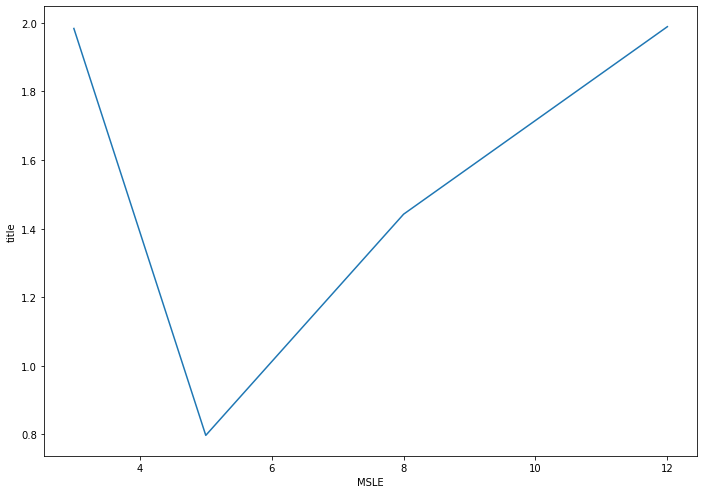

In [239]:
draw_params(max_depth_list, "max_depth")

{0: 1.9808408389543837, 0.1: 1.9825179580162406, 0.15: 0.5204871413036731, 0.2: 0.5204871413036575}


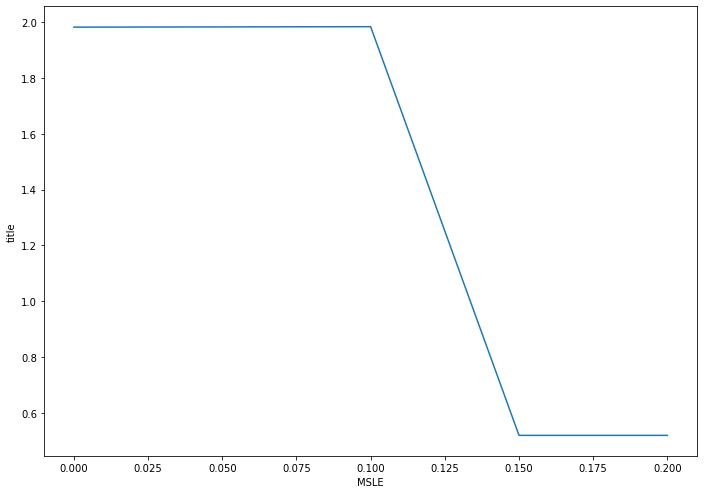

In [240]:
draw_params(min_impurity_decrease_list, "min_impurity_decrease")

{10: 1.9829560915936637, 50: 1.4307698599474388, 100: 1.4386960572382825, 500: 0.9520426718791601}


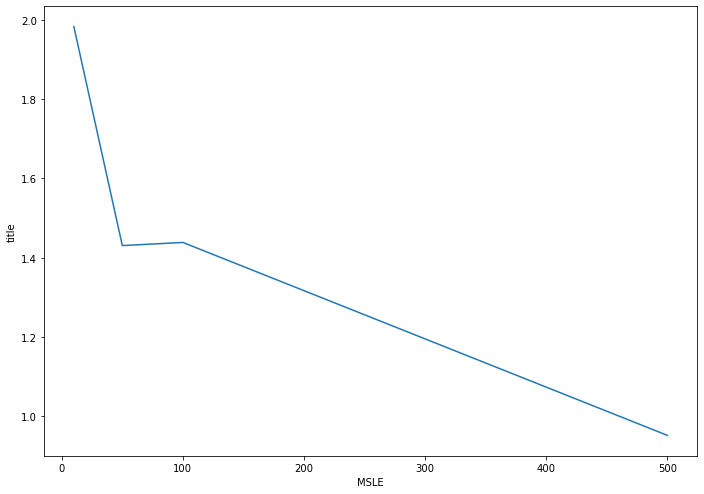

In [241]:
draw_params(min_samples_split_list, "min_samples_split")

{100: 1.9816746982154108, 200: 1.9883090342277725, 500: 1.983920532053933}


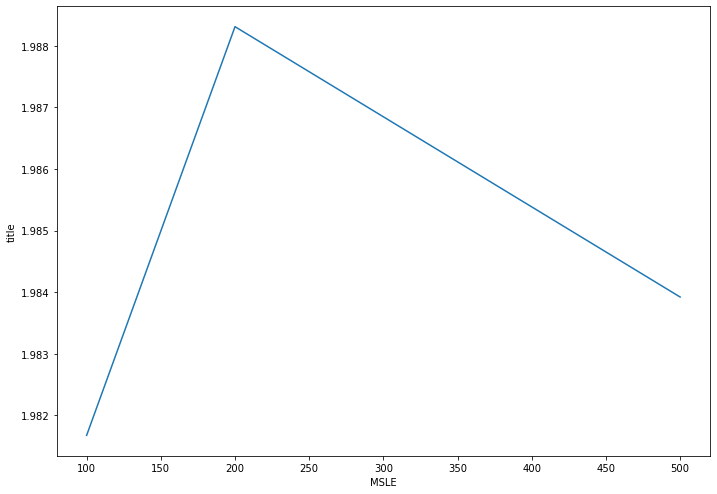

In [242]:
draw_params(max_leaf_nodes_list, "max_leaf_nodes")

Подберите лучшую комбинацию параметров, используя `GridSearchCV` и набор массивов значений параметров из предыдущего задания. Для лучшей комбинации посчитайте MSLE на тестовой выборке. Получились ли лучшие параметры такими же, как если бы вы подбирали их по-отдельности при остальных гиперпараметрах по умолчанию (предыдущее задание)? (2б)

In [244]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "decision_tree__max_depth": [3, 5, 8, 12],
    "decision_tree__min_samples_split": [10, 50, 100, 500],
    "decision_tree__min_impurity_decrease": [0, 0.1, 0.15, 0.2],
    "decision_tree__max_leaf_nodes": [100, 200, 500]
}
np.random.seed(1)

search = GridSearchCV(pipe, 
                      param_grid, 
                      cv=4,
                      scoring='neg_mean_squared_error',
                      verbose=1)

search.fit(X_train, y_train)

print(f"Best parameter (CV score={search.best_score_:.5f}):")
print(search.best_params_)

print(f"Качество лучшей модели на финальном тесте: {search.score(X_test, y_test)}")

Fitting 4 folds for each of 192 candidates, totalling 768 fits
Best parameter (CV score=-0.57883):
{'decision_tree__max_depth': 3, 'decision_tree__max_leaf_nodes': 100, 'decision_tree__min_impurity_decrease': 0.15, 'decision_tree__min_samples_split': 500}
Качество лучшей модели на финальном тесте: -0.5204871413036569
